In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from ADM import ADM

from data_loader import load_pickle, unpack_data
from mutual_information import compute_mutual_information, create_spectrogram, mutual_info_pipeline, to_spikes_and_back
sns.set()

SUBJECT_IDX = 3
num_hr_bins = 100
num_power_bins = 6

In [2]:
dataset = load_pickle(SUBJECT_IDX)

### Create spectrogram of PPG signal

<ipython-input-76-730cc4a00c75>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')


Text(0.5, 0, 'Time [s]')

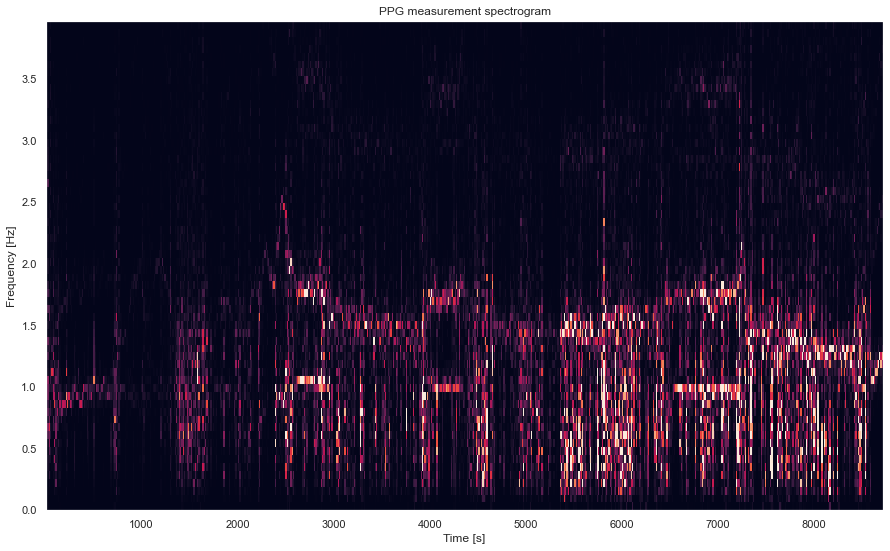

In [76]:
fs_ppg = 64
nperseg_ppg = 1000
noverlap = None
fmin = 0 # Hz
fmax = 4 # Hz

ppg, acc, hr, activity, _= unpack_data(dataset)
ppg = ppg[:-(64 * 8)]

hr_timestamps = np.arange(0, len(hr) * 2, 2)
hr_interpolation = interpolate.interp1d(hr_timestamps, hr)

### create spectrogram
f_ppg, t_ppg, Sxx_ppg = create_spectrogram(ppg, fs_ppg, nperseg_ppg, noverlap, fmin, fmax)

# interpolate relevant heart rate measurements
hr_at_ppg_timestamps = hr_interpolation(t_ppg)

### plot ppg spectrogram
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')
plt.title('PPG measurement spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

In [77]:
f_ppg

array([0.   , 0.064, 0.128, 0.192, 0.256, 0.32 , 0.384, 0.448, 0.512,
       0.576, 0.64 , 0.704, 0.768, 0.832, 0.896, 0.96 , 1.024, 1.088,
       1.152, 1.216, 1.28 , 1.344, 1.408, 1.472, 1.536, 1.6  , 1.664,
       1.728, 1.792, 1.856, 1.92 , 1.984, 2.048, 2.112, 2.176, 2.24 ,
       2.304, 2.368, 2.432, 2.496, 2.56 , 2.624, 2.688, 2.752, 2.816,
       2.88 , 2.944, 3.008, 3.072, 3.136, 3.2  , 3.264, 3.328, 3.392,
       3.456, 3.52 , 3.584, 3.648, 3.712, 3.776, 3.84 , 3.904, 3.968])

### Run PPG through ADM

In [78]:
ADM_factor = 1
ADM_step_size = ADM_factor * np.mean(abs(ppg))
up_spikes, down_spikes = ADM(
    ppg,
    up_threshold=ADM_step_size,
    down_threshold=ADM_step_size,
    sampling_rate=fs_ppg,
    refractory_period=0
)

### Reconstruct original signal from ADM-generated spike train using gaussian kernel

In [79]:
def reconstruct_from_spikes(spikes, length, spike_value):
    reconstructed_signal = np.zeros(length)
    spikes_sampling_rate_indices = (spikes * 64).astype(int)
    reconstructed_signal[spikes_sampling_rate_indices] = spike_value
    reconstructed_signal = gaussian_filter1d(reconstructed_signal, 10)
    return reconstructed_signal

In [80]:
reconstructed_signal = (
    reconstruct_from_spikes(up_spikes, len(ppg), 1) +
    reconstruct_from_spikes(down_spikes, len(ppg), -1)
)

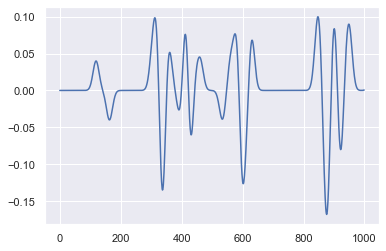

In [81]:
plot_segment_start = 100000
plot_segment_length = 1000
plt.plot(reconstructed_signal[plot_segment_start:plot_segment_start+plot_segment_length])

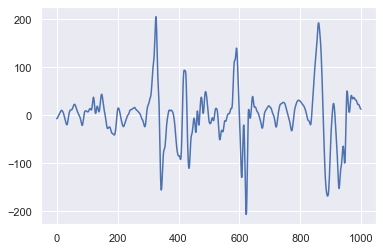

In [82]:
plt.plot(ppg[plot_segment_start:plot_segment_start+plot_segment_length])

### Create spectrogram of reconstructed signal

<ipython-input-83-b9da0cd593fa>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_rec, f_rec, Sxx_rec, shading='flat')


Text(0.5, 0, 'Time [s]')

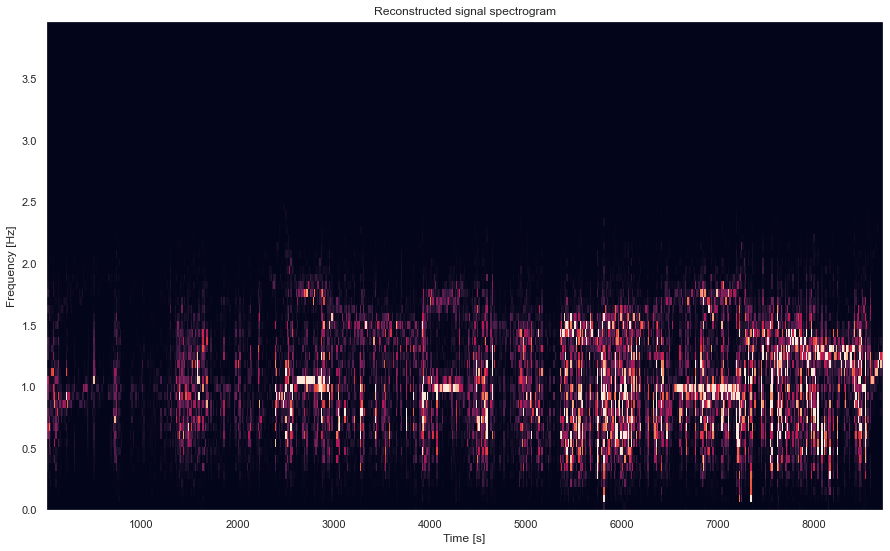

In [83]:
### create spectrogram
f_rec, t_rec, Sxx_rec = create_spectrogram(reconstructed_signal, fs_ppg, nperseg_ppg, noverlap, fmin, fmax)

### interpolate relevant heart rate measurements
hr_at_ppg_timestamps = hr_interpolation(t_rec)

### plot ppg spectrogram
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_rec, f_rec, Sxx_rec, shading='flat')
plt.title('Reconstructed signal spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

### Mutual information

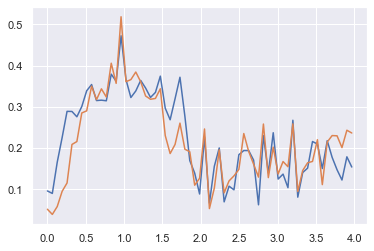

In [84]:
mutual_information_rec = compute_mutual_information(Sxx_rec, hr_at_ppg_timestamps, num_hr_bins, num_power_bins)
mutual_information_ppg = compute_mutual_information(Sxx_ppg, hr_at_ppg_timestamps, num_hr_bins, num_power_bins)
plt.plot(f_ppg, mutual_information_ppg)
plt.plot(f_rec, mutual_information_rec)

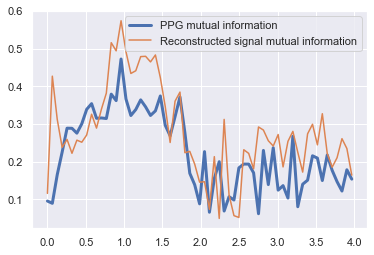

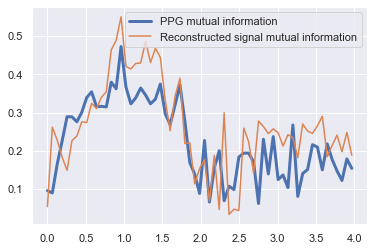

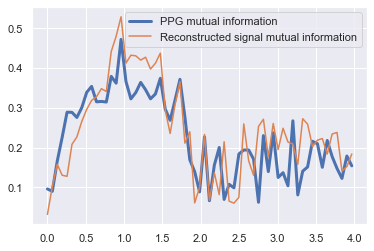

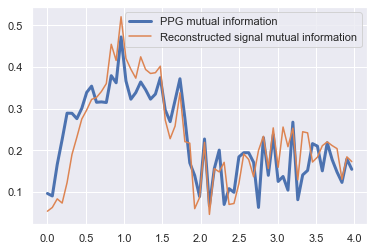

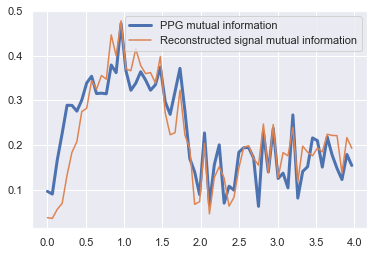

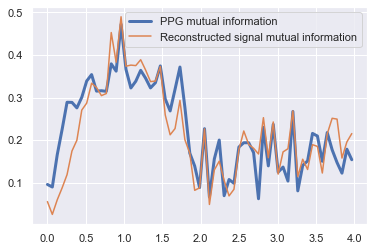

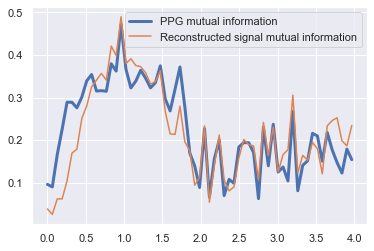

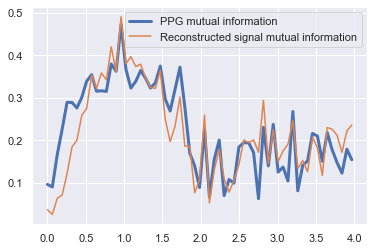

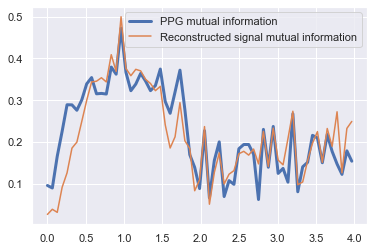

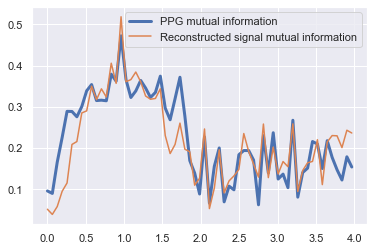

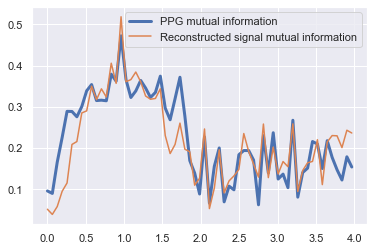

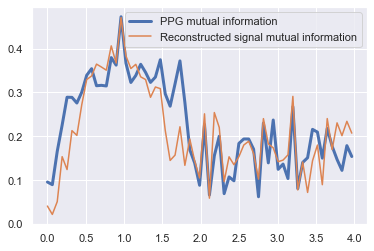

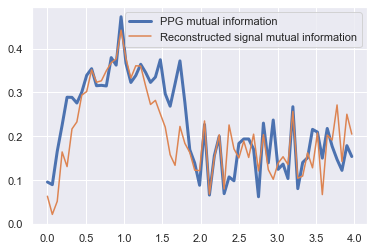

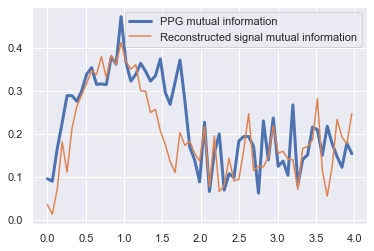

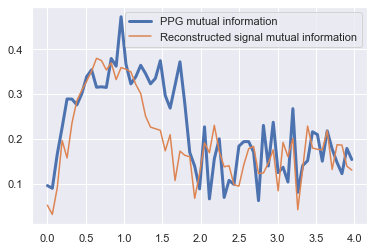

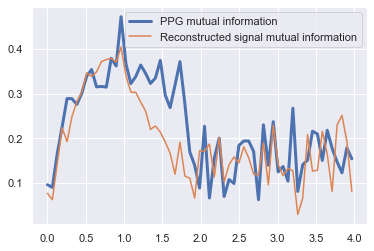

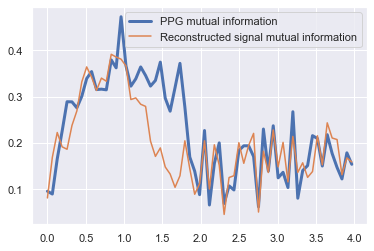

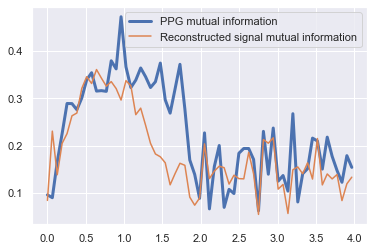

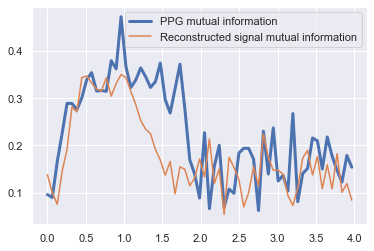

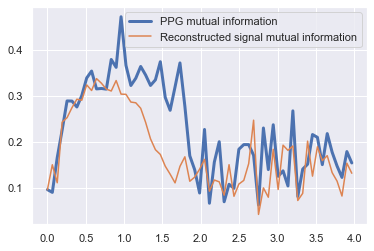

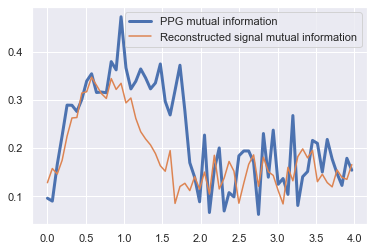

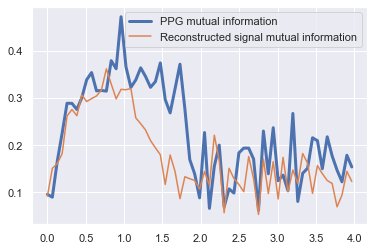

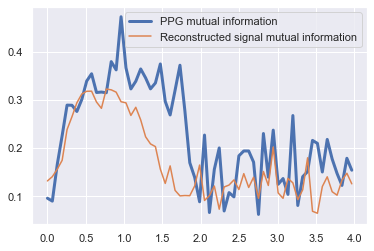

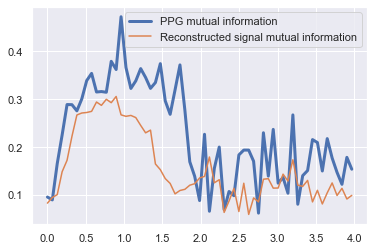

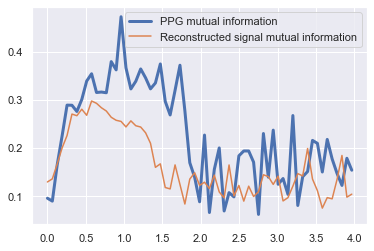

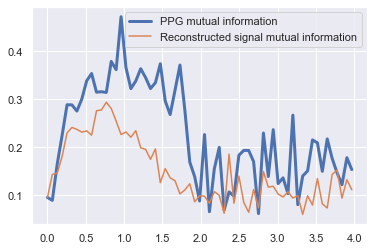

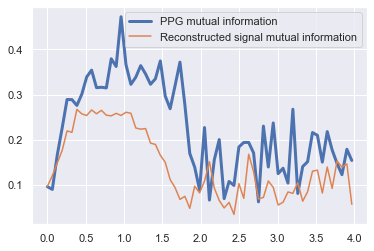

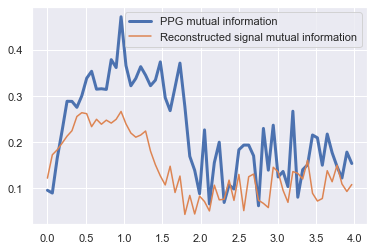

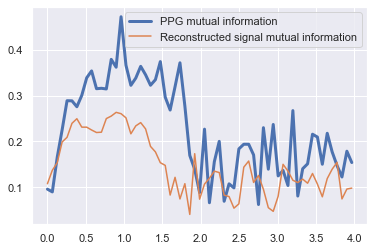

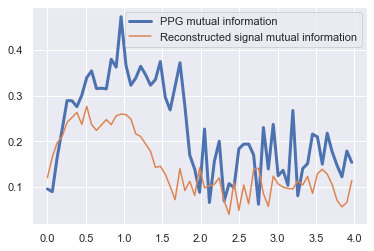

In [88]:
PLOT = True

f_ppg, mutual_information_ppg = mutual_info_pipeline(ppg, hr, fmin=fmin, fmax=fmax)

step_factor_list = np.concatenate([np.linspace(0, 1, 10), np.linspace(1, 10, 20)])
mutual_information_rec_means = []
num_spikes_list = []

for step_factor in step_factor_list:
    rec_signal, num_spikes = to_spikes_and_back(ppg, fs_ppg, step_factor)
    f_rec, mutual_information_rec = mutual_info_pipeline(rec_signal, hr, fmin=fmin, fmax=fmax)
    
    num_spikes_list.append(num_spikes)
    mutual_information_rec_means.append(mutual_information_rec.mean())
    
    if PLOT:
        plt.plot(f_ppg, mutual_information_ppg, linewidth=3, label='PPG mutual information')
        plt.plot(f_rec, mutual_information_rec, linewidth=1.5, label='Reconstructed signal mutual information')
        plt.legend()
        plt.show()

Text(0.5, 0, 'ADM step size factor')

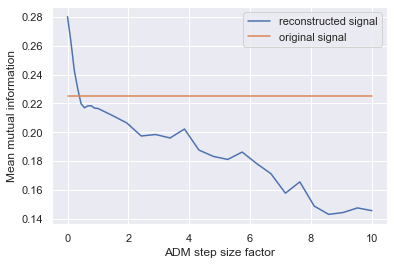

In [86]:
plt.plot(step_factor_list, mutual_information_rec_means, label='reconstructed signal')
plt.plot(step_factor_list, [mutual_information_ppg.mean()] * len(step_factor_list) , label='original signal')
plt.legend()
plt.ylabel('Mean mutual information')
plt.xlabel('ADM step size factor')

Text(0.5, 0, 'Number of spikes')

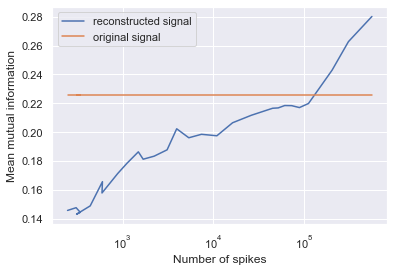

In [87]:
plt.semilogx(num_spikes_list, mutual_information_rec_means, label='reconstructed signal')
plt.plot(num_spikes_list, [mutual_information_ppg.mean()] * len(num_spikes_list) , label='original signal')
plt.legend()
plt.ylabel('Mean mutual information')
plt.xlabel('Number of spikes')